In [ ]:
# Import statements
!pip install datasets
import torch
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
import numpy as np
import re
import matplotlib.pyplot as plt

TypeError: 

In [ ]:
### Task 1 - Preprocess Data for RF and Naive Bayes###

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

def single_labels(dataset):
    return len(dataset["labels"]) == 1

# use filter() to identify instances with multiclass labels
train_single_label = ds["train"].filter(single_labels)
val_single_label = ds["validation"].filter(single_labels)
test_single_label = ds["test"].filter(single_labels)

# filtered dataset with only single label instances
ds["train"] = train_single_label
ds["validation"] = val_single_label
ds["test"] = test_single_label

# extract text and labels
def extract_data(dataset):
    texts = dataset["text"]
    labels = [label[0] for label in dataset["labels"]]
    return texts, labels

X_train, y_train = extract_data(ds["train"])
X_val, y_val = extract_data(ds["validation"])
X_test, y_test = extract_data(ds["test"])

def preprocess_text(text):  # remove non-word characters
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

## RF data transform using Count Vectorizer ##
rf_vectorizer = CountVectorizer(preprocessor=preprocess_text)
X_train_rf = rf_vectorizer.fit_transform(X_train)
X_val_rf = rf_vectorizer.transform(X_val)
X_test_rf = rf_vectorizer.transform(X_test)

## Naive Bayes data transform using bag of words representation with CountVectorizer ##
nb_vectorizer = CountVectorizer(preprocessor=preprocess_text)
X_train_nb = nb_vectorizer.fit_transform(X_train)
X_val_nb = nb_vectorizer.transform(X_val)
X_test_nb = nb_vectorizer.transform(X_test)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

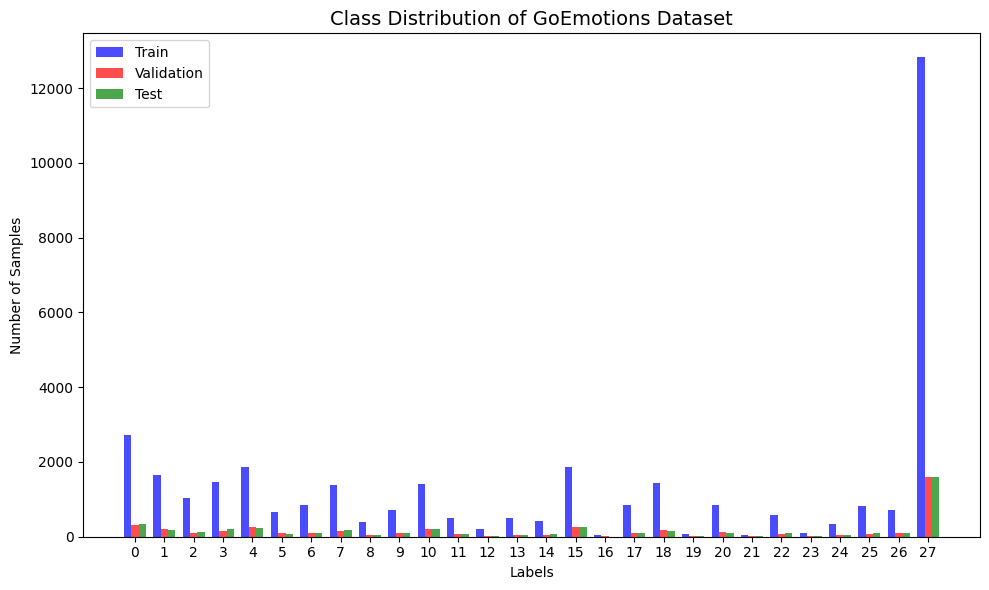

In [ ]:
# Visualization of class distribution

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Count label occurrences for each dataset
unique_labels = np.unique(np.concatenate((y_train, y_val, y_test)))
train_counts = np.array([np.sum(y_train == label) for label in unique_labels])
val_counts = np.array([np.sum(y_val == label) for label in unique_labels])
test_counts = np.array([np.sum(y_test == label) for label in unique_labels])

# Plot settings
bar_width = 0.25
x = np.arange(len(unique_labels))

# Create the bar chart
plt.figure(figsize=(10,6))
plt.bar(x, train_counts, width=bar_width, label="Train", color="blue", alpha=0.7)
plt.bar(x + bar_width, val_counts, width=bar_width, label="Validation", color="red", alpha=0.7)
plt.bar(x + 2 * bar_width, test_counts, width=bar_width, label="Test", color="green", alpha=0.7)
plt.xticks(x + bar_width, unique_labels, fontsize=10)
plt.xlabel("Labels", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)
plt.title("Class Distribution of GoEmotions Dataset", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Downsampling and Oversampling methods
def downsample(X, y, num_samples):   # downsample majority class to a set number of samples
    unique_labels = np.unique(y)
    indices = []

    for label in unique_labels:
        class_indices = np.where(y == label)[0] # find indices of the current class

        if len(class_indices) > num_samples:  # downsample instance to a max value num_samples
            selected_indices = np.random.choice(class_indices, size=num_samples, replace=False)
        else:
            selected_indices = class_indices

        indices.extend(selected_indices)

    indices = np.random.permutation(indices)

    if isinstance(X, np.ndarray):
        X_down = X[indices]
    else:
        X_down = X[indices, :]

    y_down = np.array(y)[indices]

    return X_down, y_down

def oversample(X, y, num_samples): # oversample majority class to a set number of samples
    unique_labels = np.unique(y)
    indices = []

    for label in unique_labels:
        class_indices = np.where(y == label)[0]

        if len(class_indices) < num_samples:  # Oversample if below target count
            oversampled_indices = np.random.choice(class_indices, size=num_samples - len(class_indices), replace=True)
            indices.extend(np.concatenate([class_indices, oversampled_indices]))
        else:
            indices.extend(class_indices)

    indices = np.random.permutation(indices)

    if isinstance(X, np.ndarray):
        X_oversampled = X[indices]
    else:
        X_oversampled = X[indices, :]

    y_oversampled = np.array(y)[indices]

    return X_oversampled, y_oversampled

def downsample_extreme(X, y):   # extreme downsample to the size of the smallest class
    unique_labels, label_freq = np.unique(y, return_counts=True)
    min_count = np.min(label_freq)
    indices = []

    for label in unique_labels:
        label_indices = np.where(np.array(y) == label)[0]
        sampled_indices = np.random.choice(label_indices, min_count, replace=False)
        indices.extend(sampled_indices)

    indices = np.random.permutation(indices)

    if isinstance(X, np.ndarray):
        X_balanced = X[indices]
    else:
        X_balanced = X[indices, :]

    y_balanced = np.array(y)[indices]

    return X_balanced, y_balanced


def oversample_extreme(X, y):   # extreme oversample to the size of the largest class
    unique_labels, label_freq = np.unique(y, return_counts=True)
    max_count = max(label_freq)
    indices = []

    for label in unique_labels:
        label_indices = np.where(np.array(y) == label)[0]
        sampled_indices = np.random.choice(label_indices, max_count, replace=True)
        indices.extend(sampled_indices)

    indices = np.random.permutation(indices)

    if isinstance(X, np.ndarray):
        X_balanced = X[indices]
    else:
        X_balanced = X[indices, :]

    y_balanced = np.array(y)[indices]

    return X_balanced, y_balanced

In [ ]:
# Task 2.0 - Implement Baseline Model (Random Forest)
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import itertools
import pandas as pd

# tune hyperparameters
def tune_rf(X_train, y_train, X_val, y_val, param_grid):
    best_params = None
    best_val_acc = 0
    results = []

    # Create combinations of hyperparameters
    param_combinations = itertools.product(*param_grid.values())

    # Grid search over all combinations
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))
        rf_model = RandomForestClassifier(random_state=42, **params)
        rf_model.fit(X_train, y_train)

        # Evaluate on validation set
        val_pred = rf_model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)

        results.append({'params': params, 'val_acc': val_acc})  # store accuracies

        # Update best parameters if this configuration is better
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params

    # Display results
    results_df = pd.DataFrame(results)
    print("Hyperparameter Tuning Results:")
    print(results_df)

    # Return best parameters and validation accuracy
    return {'best_params': best_params,'best_val_acc': best_val_acc}


def baseline_model_experiment(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    print(f'Train Accuracy: {train_acc}')
    print(classification_report(y_train, train_pred))

    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nValidation Accuracy: {val_acc}')

    test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nTest Accuracy: {test_acc}')
    print(classification_report(y_test, test_pred ))


In [ ]:
# Tuning parameters for random forest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
}

results = tune_rf(X_train_rf, y_train, X_val_rf, y_val, param_grid)
best_params = results['best_params']
print(f"Best Parameters: {results['best_params']}")
print(f"Best Validation Accuracy: {results['best_val_acc']}")


Hyperparameter Tuning Results:
                                               params   val_acc
0   {'n_estimators': 100, 'max_depth': 10, 'min_sa...  0.350044
1   {'n_estimators': 100, 'max_depth': 10, 'min_sa...  0.350044
2   {'n_estimators': 100, 'max_depth': 10, 'min_sa...  0.350044
3   {'n_estimators': 100, 'max_depth': 10, 'min_sa...  0.350044
4   {'n_estimators': 100, 'max_depth': 10, 'min_sa...  0.350044
..                                                ...       ...
76  {'n_estimators': 500, 'max_depth': None, 'min_...  0.529464
77  {'n_estimators': 500, 'max_depth': None, 'min_...  0.510114
78  {'n_estimators': 500, 'max_depth': None, 'min_...  0.557388
79  {'n_estimators': 500, 'max_depth': None, 'min_...  0.534081
80  {'n_estimators': 500, 'max_depth': None, 'min_...  0.508355

[81 rows x 2 columns]
Best Parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1}
Best Validation Accuracy: 0.5593667546174143


In [ ]:
# run random forest experiment
rf_model = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=1, random_state=42)

print("RF experiment with original dataset")
baseline_model_experiment(rf_model, X_train_rf, y_train, X_val_rf, y_val, X_test_rf, y_test)

# resample data (downsample to 5000 and oversample to 1200)
X_train_rf_over, y_train_rf_over = oversample(X_train_rf, y_train, 1200)
X_train_rf_od, y_train_rf_od = downsample(X_train_rf_over, y_train_rf_over, 5000)

print("\nRF experiment with resampling")
baseline_model_experiment(rf_model, X_train_rf_od, y_train_rf_od, X_val_rf, y_val, X_test_rf, y_test)

RF experiment with original dataset
Random Forest - Train Accuracy: 0.9900022033711579
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2710
           1       0.99      1.00      0.99      1652
           2       1.00      0.99      0.99      1025
           3       1.00      0.99      0.99      1451
           4       1.00      0.97      0.98      1873
           5       0.99      0.98      0.99       649
           6       1.00      0.98      0.99       858
           7       1.00      0.97      0.99      1389
           8       1.00      0.99      0.99       389
           9       1.00      0.99      0.99       709
          10       1.00      0.99      0.99      1402
          11       1.00      0.99      0.99       498
          12       1.00      1.00      1.00       203
          13       0.98      0.94      0.96       510
          14       1.00      1.00      1.00       430
          15       0.99      0.99      0.99     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest - Train Accuracy: 0.995356223382498
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2710
           1       0.99      1.00      0.99      1652
           2       1.00      1.00      1.00      1200
           3       1.00      0.99      1.00      1451
           4       1.00      0.99      0.99      1873
           5       1.00      1.00      1.00      1200
           6       1.00      0.99      1.00      1200
           7       1.00      0.99      0.99      1389
           8       1.00      1.00      1.00      1200
           9       1.00      1.00      1.00      1200
          10       1.00      0.99      0.99      1402
          11       1.00      1.00      1.00      1200
          12       1.00      1.00      1.00      1200
          13       0.97      0.99      0.98      1200
          14       1.00      1.00      1.00      1200
          15       1.00      0.99      0.99      1857
          16       1.00      1.

In [ ]:
# Task 2.1 - Implement Naive Bayes
class NaiveBayes:
    def __init__(self, num_features, num_classes):
        self.num_classes = num_classes
        self.num_features = num_features

        # initialize dictionary to store priors and likelihoods
        self.priors = {}
        self.likelihoods = {}

    def fit(self, X, y, alpha):
        N, D = X.shape
        self.classes = np.unique(y)
        class_counts = {label: 0 for label in self.classes}
        feature_counts = {label: np.zeros(self.num_features) for label in self.classes}

        # Count occurrences
        for i in range(N):
            label = y[i]
            class_counts[label] += 1
            feature_counts[label] += X[i].toarray().flatten()

        # Calculate class probabilities
        self.priors = {label: np.log(count / N) for label, count in class_counts.items()}

        # Calculate feature probabilities with Laplace smoothing
        self.likelihoods = {}
        for label in self.classes:
            feature_count = feature_counts[label] + alpha  # Laplace smoothing
            total_count = np.sum(feature_count)
            self.likelihoods[label] = np.log(feature_count / total_count)

        return self


    def predict(self, X):
        log_probs = np.zeros((X.shape[0], len(self.classes)))

        for i, x in enumerate(X):
            for j, label in enumerate(self.classes):
                log_probs[i, j] = np.sum(x.toarray().flatten() * self.likelihoods[label]) + self.priors[label]

         # Log-Sum-Exp trick for normalization
        log_probs -= log_probs.max(axis=1, keepdims=True)
        log_probs = np.exp(log_probs)
        log_probs /= log_probs.sum(axis=1, keepdims=True)  # Normalize probabilities

        # Choose class with highest log probability
        return self.classes[np.argmax(log_probs, axis=1)]


    def evaluate_acc(self, y_true, y_hat):
        return np.mean(y_true == y_hat)

def nb_experiment(model, X_train, y_train, X_test, y_test, alpha):
    model.fit(X_train, y_train, alpha)
    train_pred = model.predict(X_train)
    train_acc = model.evaluate_acc(y_train, train_pred)
    print(f'Naive Bayes - Train Accuracy: {train_acc}')
    print(classification_report(y_train, train_pred))

    test_pred = model.predict(X_test)
    test_acc = model.evaluate_acc(y_test, test_pred)
    print(f'\nNaive Bayes - Test Accuracy: {test_acc}')
    print(classification_report(y_test, test_pred ))


nb_model = NaiveBayes(num_features=X_train_nb.shape[1], num_classes=len(set(y_train))) # define naive bayes model

# resample original dataset
X_train_nb_over, y_train_nb_over = oversample(X_train_nb, y_train, 1200)
X_train_nb_od, y_train_nb_od = downsample(X_train_nb_over, y_train_nb_over, 5000)

Tuning with original dataset
Training accuracy (alpha=0.1): 0.8077283243362344
Validation accuracy (alpha=0.1): 0.46064204045734386
Training accuracy (alpha=0.2): 0.753635562410488
Validation accuracy (alpha=0.2): 0.46591908531222515
Training accuracy (alpha=0.25): 0.7251845323344718
Validation accuracy (alpha=0.25): 0.4678979771328056
Training accuracy (alpha=0.275): 0.7130109066872314
Validation accuracy (alpha=0.275): 0.46547933157431837
Training accuracy (alpha=0.3): 0.7000661011347361
Validation accuracy (alpha=0.3): 0.46547933157431837
Best alpha: 0.25


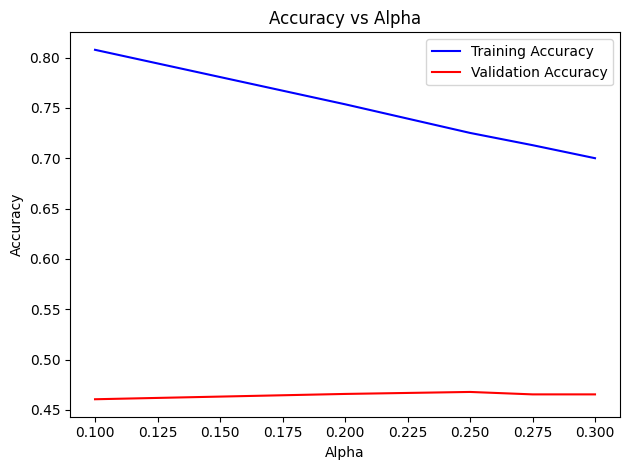


Tuning alpha with resampled dataset
Training accuracy (alpha=0.45): 0.7654772503067779
Validation accuracy (alpha=0.45): 0.45602462620932277
Training accuracy (alpha=0.5): 0.7491398185799186
Validation accuracy (alpha=0.5): 0.4619613016710642
Training accuracy (alpha=0.6): 0.7166815042948919
Validation accuracy (alpha=0.6): 0.46701846965699206
Training accuracy (alpha=0.65): 0.6993816318182912
Validation accuracy (alpha=0.65): 0.4700967458223395
Training accuracy (alpha=0.7): 0.6820817593416906
Validation accuracy (alpha=0.7): 0.47119613016710643
Training accuracy (alpha=0.75): 0.6673323548519045
Validation accuracy (alpha=0.75): 0.4716358839050132
Best alpha: 0.75


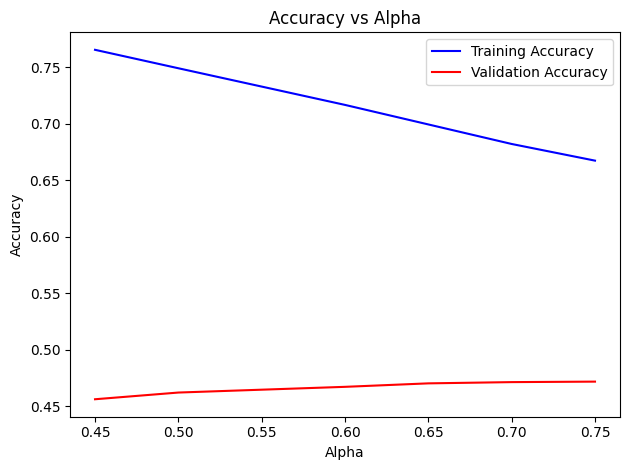

In [ ]:
def tune_alpha(model, X_train, y_train, X_val, y_val, alphas):
    best_alpha = None
    best_alpha_acc = 0
    alpha_acc = {}
    for alpha in alphas:
        model.fit(X_train, y_train, alpha=alpha)
        train_acc = model.evaluate_acc(y_train, model.predict(X_train))
        val_acc = model.evaluate_acc(y_val, model.predict(X_val))
        print(f"Training accuracy (alpha={alpha}): {train_acc}")
        print(f"Validation accuracy (alpha={alpha}): {val_acc}")
        #print(classification_report(y_val, model.predict(X_val)))
        alpha_acc[alpha] = [train_acc, val_acc]

        if val_acc > best_alpha_acc:
            best_alpha = alpha
            best_alpha_acc = val_acc

    print(f'Best alpha: {best_alpha}')

    # Plot the accuracies
    alphas = list(alpha_acc.keys())
    train_accuracies = [acc[0] for acc in alpha_acc.values()]
    val_accuracies = [acc[1] for acc in alpha_acc.values()]

    plt.figure()
    plt.plot(alphas, train_accuracies, label="Training Accuracy", color='b')
    plt.plot(alphas, val_accuracies, label="Validation Accuracy", color='r')
    plt.title("Accuracy vs Alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_alpha

# Tune alpha values
print("Tuning with original dataset")
best_alpha_full = tune_alpha(nb_model, X_train_nb, y_train, X_val_nb, y_val, alphas=[0.1, 0.2, 0.25, 0.275, 0.3])
print("\nTuning alpha with resampled dataset")
best_alpha_over = tune_alpha(nb_model, X_train_nb_od, y_train_nb_od, X_val_nb, y_val, alphas=[0.45, 0.5, 0.6, 0.65, 0.7, 0.75])


In [ ]:
# run naive bayes experiments
print('Naive Bayes Experiment for original dataset')
nb_experiment(nb_model, X_train_nb, y_train, X_test_nb, y_test, 0.25)    # original dataset

print('\nNaive Bayes Experiment for resampled dataset')
nb_experiment(nb_model, X_train_nb_od, y_train_nb_od, X_test_nb, y_test, 0.75)    # with resampling

In [ ]:
# Additional Experiment - Implementing Multiple Baselines for Comparison

# SR reference: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
# XGBoost reference: https://xgboost.readthedocs.io/en/latest/parameter.html
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

## Run baseline model experiments with default parameters
rf_model = rf_model = RandomForestClassifier()
print("Default RF experiment with original dataset")
baseline_model_experiment(rf_model, X_train_rf, y_train, X_val_rf, y_val, X_test_rf, y_test)
print("\n Default RF experiment with resampling")
baseline_model_experiment(rf_model, X_train_rf_od, y_train_rf_od, X_val_rf, y_val, X_test_rf, y_test)

sr_model = LogisticRegression(multi_class='multinomial')
print("Default SR experiment with original dataset")
baseline_model_experiment(sr_model, X_train_rf, y_train, X_val_rf, y_val, X_test_rf, y_test)
print("\nDefault SR experiment with resampling")
baseline_model_experiment(sr_model, X_train_rf_od, y_train_rf_od, X_val_rf, y_val, X_test_rf, y_test)

xgb_model = xgb.XGBClassifier()
print("Default XGBoost experiment with original dataset")
baseline_model_experiment(xgb_model, X_train_rf, y_train, X_val_rf, y_val, X_test_rf, y_test)
print("\nDefault XGBoost experiment with resampling")
baseline_model_experiment(xgb_model, X_train_rf_od, y_train_rf_od, X_val_rf, y_val, X_test_rf, y_test)


Default RF experiment with original dataset
Train Accuracy: 0.9961441004737248
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2710
           1       1.00      1.00      1.00      1652
           2       1.00      0.99      1.00      1025
           3       1.00      1.00      1.00      1451
           4       1.00      0.99      1.00      1873
           5       1.00      0.99      1.00       649
           6       1.00      0.99      1.00       858
           7       1.00      0.99      0.99      1389
           8       1.00      1.00      1.00       389
           9       1.00      1.00      1.00       709
          10       1.00      0.99      0.99      1402
          11       1.00      0.99      1.00       498
          12       1.00      1.00      1.00       203
          13       0.98      0.97      0.98       510
          14       1.00      1.00      1.00       430
          15       1.00      1.00      1.00      1857
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Accuracy: 0.9967036404321359
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2710
           1       1.00      1.00      1.00      1652
           2       1.00      1.00      1.00      1200
           3       1.00      1.00      1.00      1451
           4       1.00      1.00      1.00      1873
           5       1.00      1.00      1.00      1200
           6       1.00      0.99      1.00      1200
           7       1.00      0.99      1.00      1389
           8       1.00      1.00      1.00      1200
           9       1.00      1.00      1.00      1200
          10       1.00      1.00      1.00      1402
          11       1.00      1.00      1.00      1200
          12       1.00      1.00      1.00      1200
          13       0.97      1.00      0.98      1200
          14       1.00      1.00      1.00      1200
          15       1.00      0.99      1.00      1857
          16       1.00      1.00      1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

Train Accuracy: 0.8020821857441887
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2710
           1       0.87      0.91      0.89      1652
           2       0.84      0.71      0.77      1025
           3       0.87      0.56      0.68      1451
           4       0.87      0.55      0.67      1873
           5       0.86      0.62      0.72       649
           6       0.90      0.58      0.70       858
           7       0.87      0.56      0.68      1389
           8       0.91      0.74      0.82       389
           9       0.91      0.54      0.68       709
          10       0.85      0.57      0.68      1402
          11       0.91      0.73      0.81       498
          12       0.94      0.74      0.83       203
          13       0.88      0.53      0.66       510
          14       0.90      0.81      0.85       430
          15       0.97      0.95      0.96      1857
          16       1.00      0.51      0.68   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: Co

Train Accuracy: 0.8812107504631747
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2710
           1       0.89      0.92      0.91      1652
           2       0.86      0.83      0.84      1200
           3       0.89      0.69      0.78      1451
           4       0.84      0.69      0.76      1873
           5       0.89      0.87      0.88      1200
           6       0.90      0.79      0.84      1200
           7       0.86      0.70      0.77      1389
           8       0.95      0.98      0.97      1200
           9       0.92      0.84      0.88      1200
          10       0.84      0.72      0.78      1402
          11       0.94      0.95      0.94      1200
          12       0.97      1.00      0.99      1200
          13       0.89      0.88      0.89      1200
          14       0.95      0.98      0.96      1200
          15       0.98      0.95      0.96      1857
          16       0.99      1.00      1.00   

In [ ]:
!pip install datasets
!pip install nlpaug
!pip install scikit-learn
!pip install --upgrade scipy
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.4 MB/s eta 0:00:00
 

In [ ]:
from collections import defaultdict
import random
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertConfig, BertModel
from datasets import load_dataset, Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from accelerate import Accelerator
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from transformers import EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from transformers import get_scheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

accelerator = Accelerator()
print(f"Using device: {accelerator.device}")

Using device: cuda


In [ ]:

def load_goemotions_dataset():
    dataset = load_dataset("go_emotions", "simplified")
    return dataset["train"], dataset["validation"], dataset["test"]

def tokenize_dataset_single_label(dataset, tokenizer):
    def preprocess_function(examples):
        examples["labels"] = [label[0] if len(label) > 0 else 0 for label in examples["labels"]]
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=128
        )

    tokenized_data = dataset.map(preprocess_function, batched=True)
    tokenized_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized_data

def keep_single_label(dataset):
  return dataset.filter(lambda example: len(example["labels"]) == 1)
def plot_class_distributions(train_dataset, val_dataset, test_dataset):
    # Helper function to count labels
    def get_label_counts(dataset):
        labels = [example["labels"][0] for example in dataset]  # Extract the single label
        return Counter(labels)

    # Get label counts for each dataset
    train_counts = get_label_counts(train_dataset)
    val_counts = get_label_counts(val_dataset)
    test_counts = get_label_counts(test_dataset)

    # Extract sorted labels and counts for consistency
    all_labels = sorted(set(train_counts.keys()) | set(val_counts.keys()) | set(test_counts.keys()))
    train_distribution = [train_counts.get(label, 0) for label in all_labels]
    val_distribution = [val_counts.get(label, 0) for label in all_labels]
    test_distribution = [test_counts.get(label, 0) for label in all_labels]

    # Plotting
    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    x = range(len(all_labels))

    plt.bar(x, train_distribution, width=bar_width, label="Train", align="center")
    plt.bar([i + bar_width for i in x], val_distribution, width=bar_width, label="Validation", align="center")
    plt.bar([i + 2 * bar_width for i in x], test_distribution, width=bar_width, label="Test", align="center")

    # Labels and legend
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distributions in Train, Validation, and Test Datasets")
    plt.xticks([i + bar_width for i in x], all_labels, rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()
def load_model():
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28)
    return model

def load_model_device(device):
    config = BertConfig.from_pretrained("bert-base-uncased", num_labels=28, hidden_dropout_prob=0.3)  # Increase dropout
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
    model.to(device)
    return model

def load_model_with_hyperparams(dropout, device):
    config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=dropout)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
    model.to(device)
    return model

def evaluate_pretrained_model(model, dataloader, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    i=1
    with torch.no_grad():
        for batch in dataloader:
            if(i%100==0):
                print(f"epoch{i}")
            i+=1
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy
#ref https://huggingface.co/docs/transformers/en/main_classes/trainer
def set_training_args():
    return TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        warmup_steps=200,  # Gradual warmup
        lr_scheduler_type="linear",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=6,
        weight_decay=0.09,
        logging_dir="./logs",
        load_best_model_at_end=True,
        #fp16=True,
        dataloader_num_workers=4,
        dataloader_prefetch_factor=2,
        report_to=["none"],  # Disable W&B logging
        metric_for_best_model="eval_loss",
        save_total_limit=1
    )


def freeze_bert_layers(model):

    # Freeze all parameters in the BERT base model
    for param in model.bert.parameters():
        param.requires_grad = False

    # Unfreeze the last num encoder layers
    for layer in model.bert.encoder.layer[-6:]:
        for param in layer.parameters():
            param.requires_grad = True

    return model

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)



    return {"accuracy": accuracy}

def compute_metrics_f1(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Get predicted class
    f1 = f1_score(labels, predictions, average="weighted")  # Weighted F1 for multi-class
    accuracy = accuracy_score(labels, predictions)  # Standard accuracy
    # Generate classification report
    print("\nClassification Report:\n")
    print(classification_report(labels, predictions, zero_division=0))

    # Confusion Matrix
    # cm = confusion_matrix(labels, predictions, normalize="true")
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap="Blues", xticks_rotation="vertical")
    # plt.title("Confusion Matrix (Normalized)")
    # plt.show()

    return {"accuracy": accuracy, "f1": f1}

def compute_metrics_f1_tup(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)  # Convert logits to class predictions
    labels = np.array(labels)
    f1 = f1_score(labels, predictions, average="weighted")  # Weighted F1 for multi-class
    accuracy = accuracy_score(labels, predictions)  # Standard accuracy
    # Generate classification report
    print("\nClassification Report:\n")
    print(classification_report(labels, predictions, zero_division=0))

    #Confusion Matrix
    # cm = confusion_matrix(labels, predictions, normalize="true")
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(cmap="Blues", xticks_rotation="vertical")
    # plt.title("Confusion Matrix (Normalized)")
    # plt.show()

    return {"accuracy": accuracy, "f1": f1}

def fine_tune_model(train_dataset, val_dataset, model, training_args):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_f1,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    trainer.train()
    return trainer

def downsample_majority_class(dataset, target_count):
    label_to_samples = defaultdict(list)
    for i in range(len(dataset)):
        label = dataset[i]["labels"]
        if isinstance(label, list):  # If label is stored as a list, extract the scalar value
            label = label[0]
        label_to_samples[label].append(dataset[i])

    # Downsample overrepresented classes
    balanced_samples = []
    for label, samples in label_to_samples.items():
        if len(samples) > target_count:  # Only downsample if class size exceeds target
            downsampled_samples = random.sample(samples, target_count)
            balanced_samples.extend(downsampled_samples)
        else:
            balanced_samples.extend(samples)  # Keep other classes as is

    # Shuffle the combined dataset
    random.shuffle(balanced_samples)

    # Convert back to Hugging Face Dataset
    return Dataset.from_list(balanced_samples)

def oversample_minority_classes(dataset, target_count):

    label_to_samples = defaultdict(list)
    for i in range(len(dataset)):  # Iterate over the dataset by index
        label = dataset[i]["labels"]  # Access the label for the current sample
        if isinstance(label, list):  # If label is a list, extract the scalar value
            label = label[0]
        label_to_samples[label].append(dataset[i])  # Group samples by their labels

    # Oversample each class
    balanced_samples = []
    for label, samples in label_to_samples.items():
        if len(samples) < target_count:
            oversampled = random.choices(samples, k=target_count - len(samples))  # Duplicate samples
            balanced_samples.extend(samples + oversampled)
        else:
            balanced_samples.extend(samples)

    # Shuffle the dataset
    random.shuffle(balanced_samples)

    # Convert the list of samples back to a Hugging Face Dataset
    balanced_dataset = Dataset.from_list(balanced_samples)
    return balanced_dataset
def oversample_target_class(dataset, target_class, target_count):

    # Separate the dataset into the target class and other classes
    target_samples = [sample for sample in dataset if sample["labels"] == target_class]
    other_samples = [sample for sample in dataset if sample["labels"] != target_class]

    # Check current size of the target class
    current_count = len(target_samples)

    if current_count < target_count:
        # Oversample the target class to reach the desired count
        oversampled_samples = random.choices(target_samples, k=target_count - current_count)
        target_samples.extend(oversampled_samples)

    # Combine the oversampled target samples with other samples
    balanced_samples = target_samples + other_samples

    # Shuffle the dataset to mix the samples
    random.shuffle(balanced_samples)

    # Convert the list of samples back to a Hugging Face Dataset
    balanced_dataset = Dataset.from_list(balanced_samples)
    return balanced_dataset

In [ ]:
# %%
def pretrained_bert_inference():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_dataset, val_dataset, test_dataset = load_goemotions_dataset()

    train_dataset = keep_single_label(train_dataset).shuffle(seed=42)
    val_dataset = keep_single_label(val_dataset).shuffle(seed=42)
    test_dataset = keep_single_label(test_dataset).shuffle(seed=42)

    tokenized_test = tokenize_dataset_single_label(test_dataset, tokenizer)
    test_dataloader = torch.utils.data.DataLoader(tokenized_test, batch_size=32)

    device = accelerator.device
    model = load_model_device(device)

    accuracy = evaluate_pretrained_model(model, test_dataloader, device)
    print(f"Pretrained BERT accuracy on GoEmotions test set: {accuracy:.2%}")

In [ ]:
# %%
def train_bert():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    device = accelerator.device
    train_dataset, val_dataset, test_dataset = load_goemotions_dataset()

    train_dataset = keep_single_label(train_dataset)
    val_dataset = keep_single_label(val_dataset)
    test_dataset = keep_single_label(test_dataset)


    plot_class_distributions(train_dataset, val_dataset, test_dataset)


    tokenized_train = tokenize_dataset_single_label(train_dataset, tokenizer)
    tokenized_val = tokenize_dataset_single_label(val_dataset, tokenizer)
    tokenized_test = tokenize_dataset_single_label(test_dataset, tokenizer)


    model = load_model_device(device)
    model = freeze_bert_layers(model)
    training_args = set_training_args()
    trainer = fine_tune_model(tokenized_train, tokenized_val, model, training_args)

    test_results = trainer.evaluate(tokenized_test)
    print(f"Fine-tuned BERT accuracy on GoEmotions test set: {test_results['eval_accuracy']:.4f}")


In [ ]:
pretrained_bert_inference()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch100
Pretrained BERT accuracy on GoEmotions test set: 2.07%


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

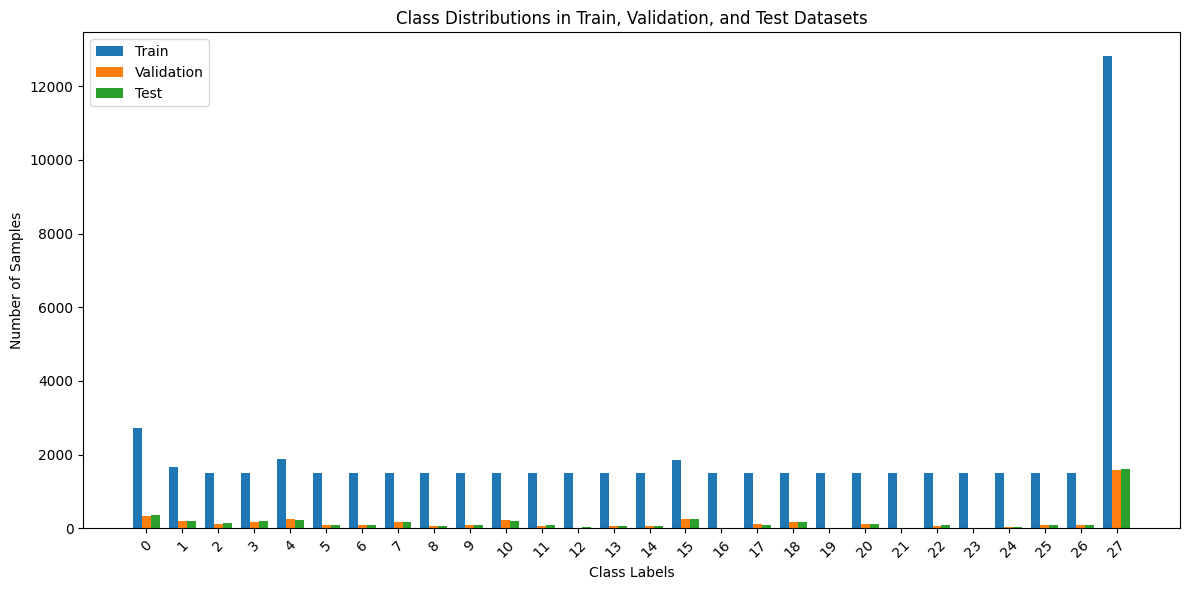

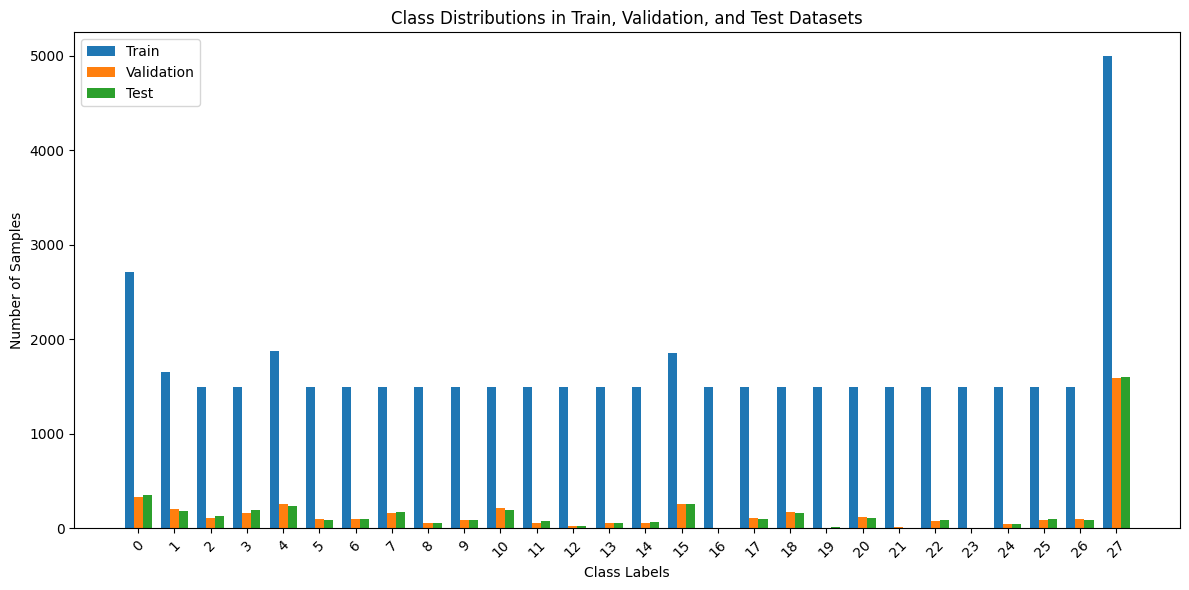

Map:   0%|          | 0/47592 [00:00<?, ? examples/s]

Map:   0%|          | 0/4548 [00:00<?, ? examples/s]

Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.074000,1.920264,0.482190,0.466482
2,1.633600,1.774288,0.511214,0.512732
3,1.439500,1.832920,0.485268,0.482555
4,1.338400,1.717273,0.508575,0.506886
5,1.255800,1.737958,0.497581,0.492508
6,1.236000,1.745582,0.497581,0.493198



Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.76      0.64       326
           1       0.68      0.66      0.67       208
           2       0.21      0.71      0.32       109
           3       0.00      0.00      0.00       164
           4       0.52      0.05      0.09       258
           5       0.29      0.55      0.38        96
           6       0.28      0.30      0.29       102
           7       0.39      0.66      0.49       164
           8       0.30      0.63      0.41        52
           9       0.28      0.09      0.13        91
          10       0.43      0.07      0.12       212
          11       0.23      0.41      0.29        61
          12       0.29      0.60      0.39        20
          13       0.20      0.25      0.22        52
          14       0.32      0.69      0.44        58
          15       0.94      0.90      0.92       261
          16       0.12      0.67      0.21         6
  


Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       348
           1       0.73      0.85      0.79       186
           2       0.32      0.58      0.41       131
           3       0.35      0.04      0.07       194
           4       0.43      0.33      0.38       236
           5       0.23      0.58      0.33        86
           6       0.31      0.51      0.38        97
           7       0.43      0.70      0.53       176
           8       0.40      0.61      0.49        56
           9       0.22      0.26      0.24        88
          10       0.34      0.43      0.38       195
          11       0.38      0.63      0.47        76
          12       0.23      0.65      0.34        23
          13       0.24      0.46      0.32        57
          14       0.42      0.75      0.54        65
          15       0.92      0.89      0.91       260
          16       0.06      0.50      0.11         2
  

In [ ]:
train_bert()

In [ ]:
!pip install sacremoses
!pip install nltk
!pip install bertviz
!pip install transformers torch ipywidgets
!pip install pretty-confusion-matrix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfu

In [ ]:

from bertviz import head_view
import random
from nltk.corpus import wordnet
import nltk
from datasets import Dataset
from collections import Counter
import nlpaug.augmenter.word as naw
from IPython.display import display, HTML
from pretty_confusion_matrix import pp_matrix
import pandas as pd

# Download NLTK resources if not already downloaded
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt') # This line is the fix

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class BertCustomModel(nn.Module):
    def __init__(self, num_labels):
        super(BertCustomModel, self).__init__()
        #Output attention matrix for viz
        self.bert = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

        #unfreeze layers
        for param in self.bert.parameters():
            param.requires_grad = True

        self.bert_dropout = nn.Dropout(0.3)
        hidden_size = self.bert.config.hidden_size
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs including attentions
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        attentions = outputs.attentions  #for viz

        # classification
        logits = self.fc2(cls_output)

        return logits, attentions #return logits for thresholding


In [ ]:
import torch.nn.functional as F
#ref https://stackoverflow.com/questions/64751157/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-dataset-for-m
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean", class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.class_weights = class_weights

    def forward(self, logits, targets):
        # cross-entropy loss
        ce_loss = F.cross_entropy(logits, targets, reduction="none", weight=self.class_weights)

        # true class prob
        probs = torch.softmax(logits, dim=1)
        pt = probs.gather(1, targets.view(-1, 1)).squeeze(1)

        # adjust for focal loss
        focal_factor = (1 - pt) ** self.gamma
        loss = self.alpha * focal_factor * ce_loss

        # Reduction (mean, sum, or none)
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [ ]:
#ref for augmentations https://responsible-ai-developers.googleblog.com/2022/11/goemotions-dataset-training-classifier.html

def balance_dataset(dataset, min_samples=200, max_samples=2000):
    # pre run for eff
    label_to_samples = {}
    for sample in dataset:
        lbl = sample["labels"][0]
        if lbl not in label_to_samples:
            label_to_samples[lbl] = []
        label_to_samples[lbl].append(sample)

    balanced_samples = []
    label_counts = {lbl: len(samps) for lbl, samps in label_to_samples.items()}

    for label, count in label_counts.items():
        samples = label_to_samples[label]

        if count < min_samples:

            augmented = augment_dataset_batch_fast(
                Dataset.from_list(samples),
                target_count=min_samples,
                batch_size=16,
                num_augmentations=3
            )

            final_samples = augmented
            if len(final_samples) > min_samples:
                final_samples = final_samples.select(range(min_samples))
            balanced_samples.extend(final_samples)
        elif count > max_samples:
            # Downsample the majority class
            balanced_samples.extend(random.sample(samples, max_samples))
        else:
            # Just use the samples as is
            balanced_samples.extend(samples)

    return Dataset.from_list(balanced_samples)


def augment_dataset_batch_fast(dataset, target_count, batch_size=16, num_augmentations=1): #more eff
    augmenters = [
        naw.SynonymAug(aug_src='wordnet'),
        naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute"),
        naw.RandomWordAug(action="delete"),
    ]

    label_counts = Counter(sample["labels"][0] for sample in dataset)
    augmented_samples = []

    # Convert the dataset to a list for easier manipulation
    data_list = list(dataset)

    for label, count in label_counts.items():
        if count < target_count:
            class_samples = [sample for sample in data_list if sample["labels"][0] == label]
            # Shuffle to avoid always augmenting the same samples first
            random.shuffle(class_samples)

            num_to_add = target_count - count
            idx = 0

            # Loop until we have the required number of augmented samples
            while num_to_add > 0:
                # Get a batch of samples to augment
                batch_samples = class_samples[idx:idx+batch_size]
                if not batch_samples:
                    # If we run out of samples, wrap around or break
                    # We'll wrap around here
                    idx = 0
                    batch_samples = class_samples[idx:idx+batch_size]
                    if not batch_samples:
                        # In case class_samples is empty for some reason
                        print("Warning: No samples to augment. Breaking out.")
                        break

                texts = [sample["text"] for sample in batch_samples]
                augmenter = random.choice(augmenters)

                # Perform augmentation num_augmentations times
                for _ in range(num_augmentations):
                    augmented_texts = augmenter.augment(texts)

                    # Safeguard: if no augmented texts returned, break
                    if not augmented_texts:
                        print("Warning: Augmentation returned no texts.")
                        break

                    # Ensure augmented_texts is a list
                    if not isinstance(augmented_texts, list):
                        augmented_texts = [augmented_texts]

                    # Add augmented samples
                    for atxt in augmented_texts:
                        augmented_samples.append({"text": atxt, "labels": [label]})

                    num_to_add -= len(augmented_texts)
                    if num_to_add <= 0:
                        break

                idx += batch_size
                # Wrap around if needed
                if idx >= len(class_samples):
                    idx = 0

    # Combine original dataset with augmented samples
    balanced_samples = data_list + augmented_samples
    random.shuffle(balanced_samples)

    return Dataset.from_list(balanced_samples)

In [ ]:
from torch.utils.data import WeightedRandomSampler
from transformers import get_cosine_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import seaborn as sns
from prettytable import PrettyTable

In [ ]:
def evaluate_on_test(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            logits = outputs.cpu().numpy()
            predictions = np.argmax(logits, axis=1)
            all_preds.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = test_loss / len(test_loader)
    test_accuracy = accuracy_score(all_labels, all_preds)

    # Generate classification report
    class_names = [
        "0: admiration", "1: amusement", "2: anger", "3: annoyance", "4: approval",
        "5: caring", "6: confusion", "7: curiosity", "8: desire", "9: disappointment",
        "10: disapproval", "11: disgust", "12: embarrassment", "13: excitement",
        "14: fear", "15: gratitude", "16: grief", "17: joy", "18: love",
        "19: nervousness", "20: optimism", "21: pride", "22: realization",
        "23: relief", "24: remorse", "25: sadness", "26: surprise", "27: neutral"
    ]

    print("\nTest Set Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("\nDetailed Classification Report Test:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds, normalize="true")
    sns.heatmap(cm, cmap='Blues')
    plt.show()
    return test_loss, test_accuracy, all_preds, all_labels


def predict_with_threshold(model, input_ids, attention_mask, threshold=0.5):
    outputs, _ = model(input_ids, attention_mask)
    probabilities = F.softmax(outputs, dim=1)

    max_probs, predictions = torch.max(probabilities, dim=1)
    # Mask predictions where confidence is below threshold
    predictions[max_probs < threshold] = -1  # or another designated "uncertain" label

    return predictions, max_probs

def evaluate_thresholds(model, test_loader, thresholds=[0.3, 0.5, 0.7, 0.9]):
    results = []
    device = accelerator.device
    for threshold in thresholds:
        correct = 0
        total = 0
        uncertain = 0

        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            predictions, confidences = predict_with_threshold(
                model, input_ids, attention_mask, threshold
            )

            # Count correct predictions and uncertain cases
            uncertain += (predictions == -1).sum().item()
            mask = predictions != -1
            correct += ((predictions == labels) & mask).sum().item()
            total += mask.sum().item()

        if total > 0:
            accuracy = correct / total
        else:
            accuracy = 0

        coverage = 1 - (uncertain / len(test_loader.dataset))
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'coverage': coverage
        })

    return results
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_attentions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs, attentions = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_attentions.extend(attentions)  # List of tuples per batch

    return all_preds, all_labels, all_attentions

def get_sample_examples(dataloader, preds, labels, num_correct, num_incorrect):
    correct_examples = []
    incorrect_examples = []


    pred_to_data_idx = {}
    curr_idx = 0
    for i, batch in enumerate(dataloader):
        batch_size = batch["input_ids"].shape[0]
        for j in range(batch_size):
            pred_to_data_idx[curr_idx] = (i, j)
            curr_idx += 1

    for i in range(len(preds)):
        if preds[i] == labels[i] and len(correct_examples) < num_correct:
            batch_idx, sample_idx = pred_to_data_idx[i]


            for batch_num, batch in enumerate(dataloader):
                if batch_num == batch_idx:
                    original_text = tokenizer.decode(batch['input_ids'][sample_idx], skip_special_tokens=True)
                    correct_examples.append((original_text, labels[i], preds[i], batch_idx, sample_idx))
                    break

        elif preds[i] != labels[i] and len(incorrect_examples) < num_incorrect:
            batch_idx, sample_idx = pred_to_data_idx[i]

            for batch_num, batch in enumerate(dataloader):
                if batch_num == batch_idx:
                    original_text = tokenizer.decode(batch['input_ids'][sample_idx], skip_special_tokens=True)
                    incorrect_examples.append((original_text, labels[i], preds[i], batch_idx, sample_idx))
                    break

        if len(correct_examples) >= num_correct and len(incorrect_examples) >= num_incorrect:
            return correct_examples, incorrect_examples

    return correct_examples, incorrect_examples

In [ ]:
def train_bert_weighted():
    device = accelerator.device
    model = BertCustomModel(num_labels=28).to(device)

    labels = [label[0] for label in train_dataset["labels"]]  #get first for some reason?

    class_counts = np.bincount(labels)
    class_weights = 1.0 / (class_counts + 10)  # Added smoothing

    # UNCOMMENT FOR WEIGHTED LOSS
    # sample_weights = [class_weights[label] for label in labels]
    # sample_weights = torch.tensor(sample_weights, dtype=torch.float)

    # sampler = WeightedRandomSampler(
    #     weights=sample_weights,
    #     num_samples=len(sample_weights),
    #     replacement=True
    # )

    # class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    # criterion_train = FocalLoss(gamma=0, class_weights=class_weights_tensor)
    criterion_train = CrossEntropyLoss(label_smoothing=0.1) #label smoothing for overfitting
    criterion_val = CrossEntropyLoss()

    optimizer = AdamW(model.parameters(), lr=2e-5,weight_decay=0.1)

    train_loader = DataLoader(
        tokenized_train,
        batch_size=8,
        #sampler=sampler,
        shuffle=True
    )

    val_loader = DataLoader(tokenized_val, batch_size=8)
    test_loader = DataLoader(tokenized_test, batch_size=8)

    epochs = 2 #overfitting after 4 so reduced for eff
    steps_per_epoch = len(train_loader)
    total_training_steps = epochs * steps_per_epoch
    warmup_steps = int(0.1 * total_training_steps)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_training_steps
    )

    model.to(device)

    # UNCOMMENT FOR DEBUGGING
    # for batch in train_loader:
    #     print("Labels shape:", batch["labels"].shape)
    #     print("Labels sample:", batch["labels"][:5])
    #     logits, attentions = model(batch["input_ids"].to(device), batch["attention_mask"].to(device))
    #     print("Outputs shape:", logits.shape)
    #     print("Class weights:", class_weights_tensor)
    #     print("Min weight:", torch.min(class_weights_tensor))
    #     print("Max weight:", torch.max(class_weights_tensor))
    #     break

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):

        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # forward
            optimizer.zero_grad()
            logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion_train(logits, labels)

            # backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # metrics
            train_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        # training metrics per epoch
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print(f"Epoch {epoch + 1}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.4f}")

        # val loop
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs, _ = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion_val(outputs, labels)
                val_loss += loss.item()

                # val metrics
                logits = outputs.cpu().numpy()
                predictions = np.argmax(logits, axis=1)
                all_preds.extend(predictions)
                all_labels.extend(labels.cpu().numpy())

                correct_val += (predictions == labels.cpu().numpy()).sum()
                total_val += labels.size(0)

        # val metrics per epoch
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch + 1}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}")

    # evaluate final model
    test_loss, test_accuracy, test_preds, test_labels = evaluate_on_test(
        model, test_loader, accelerator.device, criterion_val
    )
    print("")
    print("Final Classification Report Val:")
    class_names = [
        "0: admiration", "1: amusement", "2: anger", "3: annoyance", "4: approval", "5: caring", "6: confusion", "7: curiosity",
        "8: desire", "9: disappointment", "10: disapproval", "11: disgust", "12: embarrassment", "13: excitement",
        "14: fear", "15: gratitude", "16: grief", "17: joy", "18: love", "19: nervousness", "20: optimism", "21: pride",
        "22: realization", "23: relief", "24: remorse", "25: sadness", "26: surprise", "27: neutral"
    ]
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("")

    model.eval()
    # UNCOMMENT TO SEE THRESHOLDING COVERAGE
    # results = evaluate_thresholds(model, test_loader)


    # print("\nThreshold Analysis:")
    # for result in results:
    #    print(f"Threshold: {result['threshold']:.1f}")
    #    print(f"Accuracy: {result['accuracy']:.3f}")
    #    print(f"Coverage: {result['coverage']:.3f}\n")

    # # plot accuracy vs coverage for
    # plt.figure(figsize=(10, 6))
    # plt.plot([r['coverage'] for r in results],
    #           [r['accuracy'] for r in results],
    #           'bo-')
    # plt.xlabel('Coverage')
    # plt.ylabel('Accuracy')
    # plt.title('Accuracy vs Coverage Trade-off')
    # plt.grid(True)
    # plt.show()
    return model, tokenizer, val_loader, all_preds, all_labels


In [ ]:
#reference https://github.com/jessevig/bertviz
def visualize_attention(model, tokenizer, text, device, layer=12, head=0, remove_cls_sep=False):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        add_special_tokens=True,
        truncation=True,
        max_length=128
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        logits, attentions = model(input_ids=input_ids, attention_mask=attention_mask)

    if attentions is None:
        raise ValueError("No attention weights returned. Ensure output_attentions=True when initializing the model.")

    # Extract attention for all heads in the layer
    attention = attentions[layer]  # Shape: (num_heads, seq_len, seq_len)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    if remove_cls_sep:

        attention = attention[:, :, 1:-1, 1:-1]
        tokens = tokens[1:-1]


    # Debugging: Print shapes
    print(f"Pruned attention shape: {attention.shape}")
    print(f"Pruned tokens: {tokens}")
    # Pass the entire attention tensor for the layer to BertViz
    head_view([attention], tokens)
def visualize_all_heads(model, tokenizer, text, device, layer=6):
    model.eval()

    inputs = tokenizer.encode_plus(
        text,
        return_tensors='pt',
        add_special_tokens=True,
        truncation=True,
        max_length=128
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs, attentions = model(input_ids=input_ids, attention_mask=attention_mask)

    attention_layer = attentions[layer][0].cpu().numpy()  # Shape: [num_heads, seq_length, seq_length]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # BertViz's head_view can accept all heads for a layer
    head_view(attention_layer, tokens)
def visualize_selected_examples(model, tokenizer, dataloader, preds, labels, device, num_correct=3, num_incorrect=3, layer=6, head=8, rem=False):
    correct_examples, incorrect_examples = get_sample_examples(dataloader, preds, labels, num_correct, num_incorrect)

    print("Correctly Classified Examples:")
    for ex in correct_examples:
        # Unpack tuple directly
        text, true_label, pred_label, batch_idx, sample_idx = ex
        print(f"Text: {text}\nTrue Label: {true_label}, Predicted: {pred_label}\n")
        visualize_attention(model, tokenizer, text, device, layer=layer, head=head, remove_cls_sep=rem)

    print("\nIncorrectly Classified Examples:")
    for ex in incorrect_examples:
        # Unpack tuple directly
        text, true_label, pred_label, batch_idx, sample_idx = ex
        print(f"Text: {text}\nTrue Label: {true_label}, Predicted: {pred_label}\n")
        visualize_attention(model, tokenizer, text, device, layer=layer, head=head, remove_cls_sep=rem)


Sample train labels before tokenization: [[27], [27], [2], [14], [3], [26], [15], [0], [27], [6]]


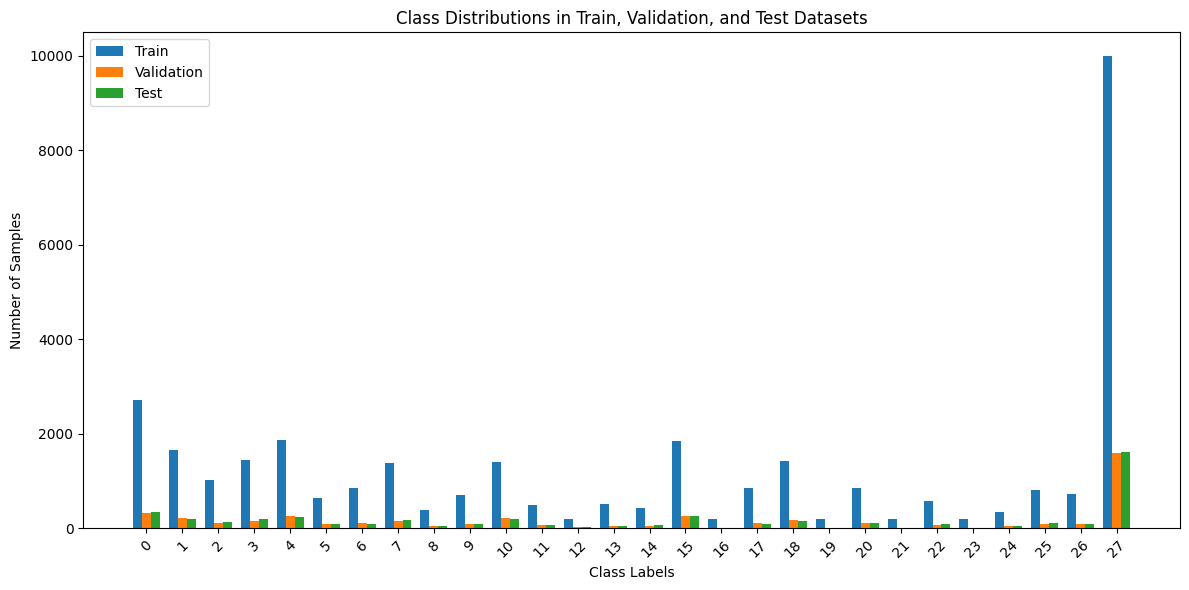

Map:   0%|          | 0/34022 [00:00<?, ? examples/s]

['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask']
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'id': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [ ]:
dataset = load_dataset("go_emotions")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset, val_dataset, test_dataset = load_goemotions_dataset()

train_dataset = keep_single_label(train_dataset)
print("Sample train labels before tokenization:", train_dataset["labels"][:10])

val_dataset = keep_single_label(val_dataset)
test_dataset = keep_single_label(test_dataset)
train_dataset = balance_dataset(train_dataset,200,10000) #add a few augmnetations if needed

plot_class_distributions(train_dataset, val_dataset, test_dataset)

tokenized_train = tokenize_dataset_single_label(train_dataset, tokenizer)
tokenized_val = tokenize_dataset_single_label(val_dataset, tokenizer)
tokenized_test = tokenize_dataset_single_label(test_dataset, tokenizer)

print(tokenized_train.column_names)
print(tokenized_train.features)


In [ ]:
print(tokenized_train.column_names)
print(tokenized_train.features)

model, tokenizer, val_loader, all_preds, all_labels = train_bert_weighted()

# Visualize examples


['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask']
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'id': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Labels shape: torch.Size([8])
Labels sample: tensor([27, 27, 21,  2,  0])
Outputs shape: torch.Size([8, 28])
Class weights: tensor([3.6765e-04, 6.0168e-04, 9.6618e-04, 6.8446e-04, 5.3107e-04, 1.5175e-03,
        1.1521e-03, 7.1480e-04, 2.5063e-03, 1.3908e-03, 7.0822e-04, 1.9685e-03,
        4.6948e-03, 1.9231e-03, 2.2727e-03, 5.3562e-04, 4.7619e-03, 1.1587e-03,
        6.9589e-04, 4.7619e-03, 1.1481e-03, 4.7619e-03, 1.6779e-03, 4.7619e-03,
        2.7548e-03, 1.2092e-03, 1.3699e-03, 9.9900e-05], device='cuda:0')
Min weight: tensor(9.9900e-05, dev

Training Epoch 1:   3%|▎         | 138/4253 [00:07<03:34, 19.21it/s]

In [ ]:
visualize_selected_examples(
        model=model,
        tokenizer=tokenizer,
        dataloader=val_loader,
        preds=all_preds,
        labels=all_labels,
        device=accelerator.device,
        num_correct=3,
        num_incorrect=3,
        layer=6,
        head=8
    )
#RUN WITH AND WITHOUT CLS SEP
visualize_selected_examples(
        model=model,
        tokenizer=tokenizer,
        dataloader=val_loader,
        preds=all_preds,
        labels=all_labels,
        device=accelerator.device,
        num_correct=3,
        num_incorrect=3,
        layer=6,
        head=8,
        rem=True
    )

Correctly Classified Examples:
Text: i've never been this sad in my life!
True Label: 25, Predicted: 25

Pruned attention shape: torch.Size([1, 12, 13, 13])
Pruned tokens: ['[CLS]', 'i', "'", 've', 'never', 'been', 'this', 'sad', 'in', 'my', 'life', '!', '[SEP]']


<IPython.core.display.Javascript object>

Text: thank you for your vote of confidence, but we statistically can't get to 10 wins.
True Label: 15, Predicted: 15

Pruned attention shape: torch.Size([1, 12, 22, 22])
Pruned tokens: ['[CLS]', 'thank', 'you', 'for', 'your', 'vote', 'of', 'confidence', ',', 'but', 'we', 'statistical', '##ly', 'can', "'", 't', 'get', 'to', '10', 'wins', '.', '[SEP]']


<IPython.core.display.Javascript object>

Text: there it is!
True Label: 27, Predicted: 27

Pruned attention shape: torch.Size([1, 12, 6, 6])
Pruned tokens: ['[CLS]', 'there', 'it', 'is', '!', '[SEP]']


<IPython.core.display.Javascript object>


Incorrectly Classified Examples:
Text: is this in new orleans?? i really feel like this is new orleans.
True Label: 27, Predicted: 7

Pruned attention shape: torch.Size([1, 12, 18, 18])
Pruned tokens: ['[CLS]', 'is', 'this', 'in', 'new', 'orleans', '?', '?', 'i', 'really', 'feel', 'like', 'this', 'is', 'new', 'orleans', '.', '[SEP]']


<IPython.core.display.Javascript object>

Text: he could have easily taken a real camera from a legitimate source and change the price in word / photoshop and then print it out.
True Label: 20, Predicted: 27

Pruned attention shape: torch.Size([1, 12, 29, 29])
Pruned tokens: ['[CLS]', 'he', 'could', 'have', 'easily', 'taken', 'a', 'real', 'camera', 'from', 'a', 'legitimate', 'source', 'and', 'change', 'the', 'price', 'in', 'word', '/', 'photos', '##hop', 'and', 'then', 'print', 'it', 'out', '.', '[SEP]']


<IPython.core.display.Javascript object>

Text: wah mum other people call me on my bullshit and i can't ban them, go out side son.
True Label: 2, Predicted: 3

Pruned attention shape: torch.Size([1, 12, 24, 24])
Pruned tokens: ['[CLS]', 'wah', 'mum', 'other', 'people', 'call', 'me', 'on', 'my', 'bullshit', 'and', 'i', 'can', "'", 't', 'ban', 'them', ',', 'go', 'out', 'side', 'son', '.', '[SEP]']


<IPython.core.display.Javascript object>

Correctly Classified Examples:
Text: i've never been this sad in my life!
True Label: 25, Predicted: 25

Pruned attention shape: torch.Size([1, 12, 11, 11])
Pruned tokens: ['i', "'", 've', 'never', 'been', 'this', 'sad', 'in', 'my', 'life', '!']


<IPython.core.display.Javascript object>

Text: thank you for your vote of confidence, but we statistically can't get to 10 wins.
True Label: 15, Predicted: 15

Pruned attention shape: torch.Size([1, 12, 20, 20])
Pruned tokens: ['thank', 'you', 'for', 'your', 'vote', 'of', 'confidence', ',', 'but', 'we', 'statistical', '##ly', 'can', "'", 't', 'get', 'to', '10', 'wins', '.']


<IPython.core.display.Javascript object>

Text: there it is!
True Label: 27, Predicted: 27

Pruned attention shape: torch.Size([1, 12, 4, 4])
Pruned tokens: ['there', 'it', 'is', '!']


<IPython.core.display.Javascript object>


Incorrectly Classified Examples:
Text: is this in new orleans?? i really feel like this is new orleans.
True Label: 27, Predicted: 7

Pruned attention shape: torch.Size([1, 12, 16, 16])
Pruned tokens: ['is', 'this', 'in', 'new', 'orleans', '?', '?', 'i', 'really', 'feel', 'like', 'this', 'is', 'new', 'orleans', '.']


<IPython.core.display.Javascript object>

Text: he could have easily taken a real camera from a legitimate source and change the price in word / photoshop and then print it out.
True Label: 20, Predicted: 27

Pruned attention shape: torch.Size([1, 12, 27, 27])
Pruned tokens: ['he', 'could', 'have', 'easily', 'taken', 'a', 'real', 'camera', 'from', 'a', 'legitimate', 'source', 'and', 'change', 'the', 'price', 'in', 'word', '/', 'photos', '##hop', 'and', 'then', 'print', 'it', 'out', '.']


<IPython.core.display.Javascript object>

Text: wah mum other people call me on my bullshit and i can't ban them, go out side son.
True Label: 2, Predicted: 3

Pruned attention shape: torch.Size([1, 12, 22, 22])
Pruned tokens: ['wah', 'mum', 'other', 'people', 'call', 'me', 'on', 'my', 'bullshit', 'and', 'i', 'can', "'", 't', 'ban', 'them', ',', 'go', 'out', 'side', 'son', '.']


<IPython.core.display.Javascript object>

In [ ]:
#reference https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_class_text_classification_BERT.ipynb
class BertMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels=28, dropout_rate=0.3):
        super(BertMultiLabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # CLS token representation
        cls_output = outputs.last_hidden_state[:, 0, :]

        # Dropout then linear layer
        x = self.dropout(cls_output)
        logits = self.classifier(x)  # [batch_size, num_labels]

        return logits

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
):
    device=accelerator.device
    epochs=5
    model.to(device)

    optimizer = AdamW(model.parameters(), 2e-5)

    total_steps = len(train_loader) * epochs
    #ref https://stackoverflow.com/questions/60120043/optimizer-and-scheduler-for-bert-fine-tuning
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    criterion = nn.BCEWithLogitsLoss() #used binary CE cause it was the simplest

    best_val_f1 = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 10)

        model.train()
        total_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # one-hot encode labels
            labels = torch.zeros(batch["labels"].shape[0], num_labels).to(device)
            #UNCOMMENT FOR DEBUGGING
            #print("labels",labels.shape)
            #print("label",batch["labels"].shape)
            #print("label value",batch["labels"][0][0])
            for i, label_indices in enumerate(batch["labels"]):

                for label_index in label_indices:

                    if label_index.item() != -1:  # Ignore padding (-1)
                        labels[i, label_index.item()] = 1  # Set 1 for the corresponding label index

            labels = labels.float()  # Convert to float


            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, labels)


            loss = loss * batch["labels_mask"].to(device).unsqueeze(-1).type(loss.dtype)
            loss = loss.sum() / batch["labels_mask"].sum() tch

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #stability
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")


        model.eval()
        total_val_loss = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)

                #one hot
                labels = torch.zeros(batch["labels"].shape[0], num_labels).to(device)
                for i, label_indices in enumerate(batch["labels"]):
                    for label_index in label_indices:
                        if label_index.item() != -1:
                            labels[i, label_index.item()] = 1

                labels = labels.float()  # Convert to float

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy()
                all_labels.append(labels.cpu().numpy())  # Append the one-hot encoded labels
                all_preds.append(preds)

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Calculate F1 Score
        all_labels = np.vstack(all_labels)
        all_preds = np.vstack(all_preds)
        all_preds_binary = (all_preds > 0.5).astype(int)
        val_f1 = f1_score(all_labels, all_preds_binary, average='macro')
        history['val_f1'].append(val_f1)
        print(f"Validation Macro F1: {val_f1:.4f}")



    return model, history

In [ ]:
def print_classification_report(report, target_names):



    table = PrettyTable()
    table.field_names = ["Class", "Precision", "Recall", "F1-score", "Support"]

    for class_name in target_names:
        metrics = report[class_name]
        table.add_row([
            class_name,
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            int(metrics['support'])
        ])

    # Add macro and weighted averages
    table.add_row(["Macro Avg", f"{report['macro avg']['precision']:.2f}",
                   f"{report['macro avg']['recall']:.2f}",
                   f"{report['macro avg']['f1-score']:.2f}",
                   int(report['macro avg']['support'])])

    table.add_row(["Weighted Avg", f"{report['weighted avg']['precision']:.2f}",
                   f"{report['weighted avg']['recall']:.2f}",
                   f"{report['weighted avg']['f1-score']:.2f}",
                   int(report['weighted avg']['support'])])

    print(table)

In [ ]:
#ref https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders
# for some reason dataloaders don't work without the collate function
def custom_collate_fn(batch):
    # Pad labels to the maximum number in the batch
    max_labels = max(len(item['labels']) for item in batch)

    # Pad all labels and create a mask indicating original label length
    padded_labels = []
    labels_mask = []

    for item in batch:
        num_labels = len(item['labels'])

        # Pad with -1 (or a value outside your label range) to max_labels
        # Convert the list to a Tensor before adding
        padded_item_labels = torch.cat([item['labels'], torch.tensor([-1] * (max_labels - num_labels), dtype=item['labels'].dtype)])
        padded_labels.append(padded_item_labels)

        # Create mask with 1s where original labels are and 0s for padding
        mask = [1] * num_labels + [0] * (max_labels - num_labels)
        labels_mask.append(mask)

    # Create dictionary for padded batch
    collated_batch = {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'labels': torch.stack(padded_labels), # Stack the padded labels
        'labels_mask': torch.tensor(labels_mask, dtype=torch.bool)
    }

    return collated_batch

dataset = load_dataset("go_emotions")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset, val_dataset, test_dataset = load_goemotions_dataset()

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=30)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

num_labels = 28
model = BertMultiLabelClassifier(num_labels=num_labels, dropout_rate=0.3)

trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader
)






Epoch 1/5
----------
Training Loss: 0.0000
Validation Loss: 0.1001
Validation Macro F1: 0.2473

Epoch 2/5
----------
Training Loss: 0.0000
Validation Loss: 0.0888
Validation Macro F1: 0.4094

Epoch 3/5
----------
Training Loss: 0.0000
Validation Loss: 0.0862
Validation Macro F1: 0.4279

Epoch 4/5
----------
Training Loss: 0.0000
Validation Loss: 0.0877
Validation Macro F1: 0.4457

Epoch 5/5
----------
Training Loss: 0.0000
Validation Loss: 0.0891
Validation Macro F1: 0.4497
